In [ ]:
# Run this cell to mount your Google Drive.

from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


## Imports

In [ ]:
#-------------------------------------------------------------------------------
# The following code was originally written by Todd Neller in Java.
# It was translated into Python by Anthony Hein.
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# A class for modeling a game of Gin Rummy
# @author Todd W. Neller
# @version 1.0
#-------------------------------------------------------------------------------

#-------------------------------------------------------------------------------
# Copyright (C) 2020 Todd Neller
#
# This program is free software; you can redistribute it and/or
# modify it under the terms of the GNU General Public License
# as published by the Free Software Foundation; either version 2
# of the License, or (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU General Public License for more details.
#
# Information about the GNU General Public License is available online at:
#   http://www.gnu.org/licenses/
# To receive a copy of the GNU General Public License, write to the Free
# Software Foundation, Inc., 59 Temple Place - Suite 330, Boston, MA
# 02111-1307, USA.
#-------------------------------------------------------------------------------

%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import random
import time
from Deck import Deck
from GinRummyUtil import GinRummyUtil
from SimpleGinRummyPlayer import SimpleGinRummyPlayer
from OpponentHandEstimationPlayer import OpponentHandEstimationPlayer

%cd /content/drive/My Drive/Colab Notebooks/Thesis
#-------------------------------------------------------------------------------
# TRACKING
import numpy as np
# tracking_states = []
# tracking_states2 = []
# tracking_hands = []
# tracking_handsO = []
curr_hand = []
knock = []
winloss = []

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    # Changed the suits to match rlcard
    suitNames = ['S', 'H', 'D', 'C']#["C", "H", "S", "D"]
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret
#-------------------------------------------------------------------------------

# MLP Part

## Shared Functions

### Imports

In [ ]:
import copy
import numpy as np
import pandas as pd
import time
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import torch.utils.data as data
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
import itertools

### cardDataset Class

In [ ]:
class cardDataset(data.Dataset):

    def __init__(self, features, labels):

        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, index):
        return self.features[index], self.labels[index]

### Balance

In [ ]:
def balance(states, labels):
    states_one = states[labels == 1]
    states_zero = states[labels == 0]
    one = labels[labels == 1]
    zero = labels[labels == 0]

    random_indices = np.random.choice(len(zero), size=len(one), replace=False)
    states_zero = states_zero[random_indices]
    zero = zero[random_indices]

    labels_bal = np.concatenate((one, zero))
    states_bal = np.concatenate((states_one, states_zero))
    return states_bal, labels_bal

### Load Data and Model

In [ ]:
def load_data(data, label, batch_size=1000, shuffle=False):
    '''
    Load dataset according to batch_size given
    '''
    data_set = cardDataset(data, label)
    data_loader = DataLoader(data_set, batch_size=batch_size, shuffle=shuffle)
    return data_loader

def load_model(lr=None, input_size=None, model=None):
    loss_fnc = torch.nn.BCELoss()
    if model is None:
        # try:
        #     model = MLP(input_size).cuda()
        # except:
        model = MLP(input_size)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        return model, loss_fnc, optimizer
    return model, loss_fnc, _

### Evaluate

In [ ]:
def evaluate(model, data_loader, loss_fnc):

    total_corr = 0
    accum_loss = 0
    for i, data in enumerate(data_loader):
        inputs, labels = data
        inputs = inputs.type(torch.FloatTensor)
        labels = labels.type(torch.FloatTensor)
        outputs = model(inputs)
        # try:
        #     vanswer = vlabels.cuda()
        #     vbatch_loss = vloss_fnc(input=voutputs, target=vlabels.long().cuda())
        # except:
        batch_loss = loss_fnc(input=outputs.squeeze(), target=labels.squeeze())

        guess = outputs > 0.5
        answer = labels

        corr = guess.flatten().float() == answer.float()
        total_corr += int(corr.sum())
        accum_loss += batch_loss

    acc = float(total_corr)/len(data_loader.dataset)
    loss = accum_loss/(i+1)
    return acc, loss.item() 

### Train

In [ ]:
def train(train_loader, val_loader, batch_size, lr, epochs, verbose=False):

    input_size = len(train_loader.dataset.features[0])
    # input_size = data_train.shape[1]
    model, loss_fnc, optimizer = load_model(lr, input_size)

    max_val_acc = 0
    min_val_loss = np.inf
    train_acc, train_loss = [], []
    val_acc, val_loss = [], []
    start_time = time.time()

    for epoch in range(epochs):
        accum_loss = 0
        total_corr = 0
        for i, data in enumerate(train_loader):
            inputs, labels = data
            inputs = inputs.type(torch.FloatTensor)
            labels = labels.type(torch.FloatTensor)
            
            optimizer.zero_grad()
            
            outputs = model(inputs)
            # try:
                # batch_loss = loss_fnc(input=outputs, target=labels.long().cuda())
            # except:
            batch_loss = loss_fnc(input=outputs.squeeze(), target=labels.squeeze())
            accum_loss += batch_loss
            batch_loss.backward()
            optimizer.step()

            guess = (outputs > 0.5)
            # print(guess)
            # try:
                # answer = labels.cuda()
            # except:
            answer = labels
            # print(labels)
            corr = guess.flatten() == answer
            total_corr += int(corr.sum())

        # evaluate per epoch
        vacc, vloss = evaluate(model, val_loader, loss_fnc)
        val_acc.append(vacc)
        val_loss.append(vloss)
        train_loss.append(accum_loss.item()/(i+1))
        train_acc.append(float(total_corr)/len(train_loader.dataset))
        # best acc model
        if vacc > max_val_acc:
            max_val_acc = vacc
            epoch_acc = epoch
            model_acc = copy.deepcopy(model) 
        # best loss model
        if vloss < min_val_loss:
            min_val_loss = vloss
            epoch_loss = epoch
            model_loss = copy.deepcopy(model)

        if verbose:
            # print records
            print("Epoch: {} | Train Loss: {:.8f} | Train acc: {:.6f}"
                .format(epoch + 1, train_loss[epoch], train_acc[epoch]))
            print("              Val Loss: {:.8f} |   Val acc: {:.6f}"
                .format(val_loss[epoch], val_acc[epoch]))
        accum_loss = 0.0
        total_corr = 0


    print('Finished Training')
    end_time = time.time()
    elapsed_time = end_time - start_time
    print("Total training time elapsed: {:.2f} seconds".format(elapsed_time))
    plotTrain(train_acc, val_acc, epoch_acc, 'Accuracy')
    plotTrain(train_loss, val_loss, epoch_loss, 'Loss')

    return model, model_acc, model_loss

### Plot Functions

In [ ]:
def plotTrain(train, val, epoch, label):
    plt.figure()
    plt.title("{} vs. Epoch".format(label), fontsize=14)
    plt.xlabel("Epochs", fontsize=12)
    plt.ylabel(label, fontsize=12)
    plt.plot(train, label='Training {}'.format(label))
    plt.plot(val, label='Validation {}'.format(label))
    plt.axvline(epoch, color='red', label='Best Epoch: {}'.format(epoch+1))
    plt.plot(epoch, val[epoch], marker='o', color="red", label="{}: {:.4f}"
             .format(label, val[epoch]))
    plt.legend()
    plt.show()
    plt.close()


def evaluate_confusion_matrix(model, data_loader):
    """
    Run the model on the test set and generate the confusion matrix.

    Args:
        model: PyTorch neural network object
        data_loader: PyTorch data loader for the dataset
    Returns:
        cm: A NumPy array denoting the confusion matrix
    """
    val_labels = np.array([], dtype=np.int64)
    val_preds = np.array([], dtype=np.int64)

    for i, data in enumerate(data_loader, 0):
        vinputs, vlabels = data
        vinputs = vinputs.type(torch.FloatTensor)
        vlabels = vlabels.type(torch.FloatTensor)
        voutputs = model(vinputs)
        vguess = (voutputs > 0.5).flatten()
        val_labels = np.concatenate((val_labels, vlabels))
        val_preds = np.concatenate((val_preds, vguess))

    cm = confusion_matrix(val_labels, val_preds)
    print('Accuracy: {:.2f}'.format(100*(val_labels == val_preds).sum() /len(val_labels)))
    return cm


# Function based off
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.

    Args:
        cm: A NumPy array denoting the confusion matrix
        classes: A list of strings denoting the name of the classes
        normalize: Boolean whether to normalize the confusion matrix or not
        title: String for the title of the plot
        cmap: Colour map for the plot
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    print(cm)

    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
    return

def plot_cm(classes, model, data_loader):

    cm = evaluate_confusion_matrix(model, data_loader)
    plot_confusion_matrix(cm, classes,
                        normalize=True,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)
    plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues)

## Knock Model

### Model

#### input_size*2 HU Model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, input_size*2)
        self.l2 = nn.Linear(input_size*2, 1)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        # try:
        #     x = self.l1(features.cuda())
        # except:
        #     x = self.l1(features)
        x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

#### 305 HU Model

- 305 equals the total number of possible Melds

Runs = 240 possibilities
- For a given suit = 60 possibilities
 - 11 runs of three cards 
 - 10 runs of four cards 
 - 9 runs of five cards
 - 8 runs of six cards
 - 7 runs of seven cards
 - 6 runs of eight cards
 - 5 runs of nine cards
 - 4 runs of ten cards

Sets = 65 possibilities
- For each rank = 5 possiblities
 - 4C3 = 4 ways for a three set
 - 4C4 = 1 way for a four set

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, 305)
        self.l2 = nn.Linear(305, 1)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        # try:
        #     x = self.l1(features.cuda())
        # except:
        #     x = self.l1(features)
        x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

### Training

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy')

states_bal, labels_bal = balance(states, labels)
data_train, data_val, label_train, label_val = train_test_split(states_bal, labels_bal, test_size=0.3, random_state=421)

Finished Training
Total training time elapsed: 425.30 seconds


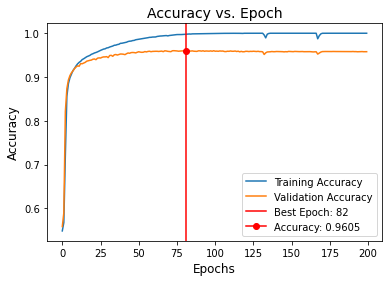

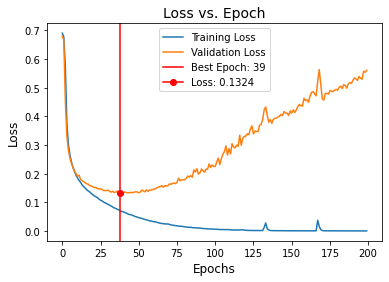

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 200
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs)
# torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model.pt')
# torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_acc.pt')
# torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_loss.pt')

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/apad/knock_bin_s_8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/apad/knock_bin_a_8k.npy')

states_bal, labels_bal = balance(states, labels)
data_train, data_val, label_train, label_val = train_test_split(states_bal, labels_bal, test_size=0.3, random_state=421)

Finished Training
Total training time elapsed: 257.69 seconds


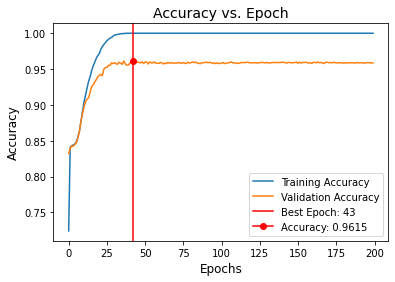

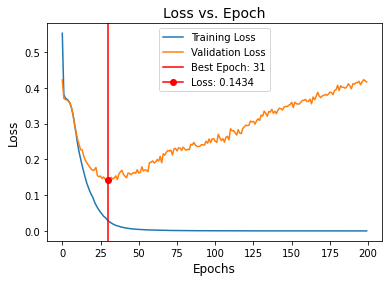

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 200
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs)
# torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model.pt')
# torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_acc.pt')
# torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_loss.pt')

### 52x5 input

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k.npy')

states_bal, labels_bal = balance(states, labels)
z = np.zeros([states_bal.shape[0],states_bal.shape[1]*4])
states_bal = np.append(states_bal, z, axis=1)
data_train, data_val, label_train, label_val = train_test_split(states_bal, labels_bal, test_size=0.3, random_state=421)
batch_size = 1000
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

Finished Training
Total training time elapsed: 816.29 seconds


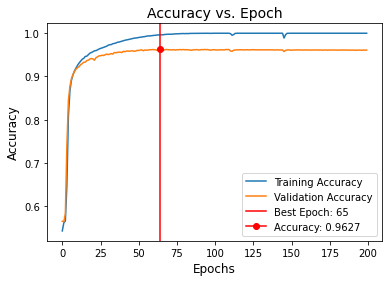

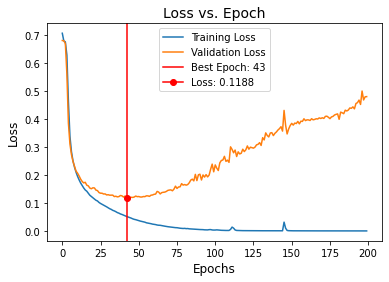

In [ ]:
# Training parameters
batch_size = 1000
lr = 0.01
epochs = 200
train_loader = load_data(data_train, label_train, batch_size, shuffle=True)
val_loader = load_data(data_val, label_val, batch_size, shuffle=False)

model, model_acc, model_loss = train(train_loader, val_loader, batch_size, lr, epochs)
# torch.save(model, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt')
# torch.save(model_acc, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model_acc.pt')
# torch.save(model_loss, '/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model_loss.pt')

### Confusion Matrix

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model.pt')
# model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_acc.pt')
# model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_loss.pt')

model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/305/model.pt')

# model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt')

classes = ["No Knock", "Knock"]

#### Train Set (Balanced)

Accuracy: 97.64
Normalized confusion matrix
[[0.9528036 0.0471964]
 [0.        1.       ]]


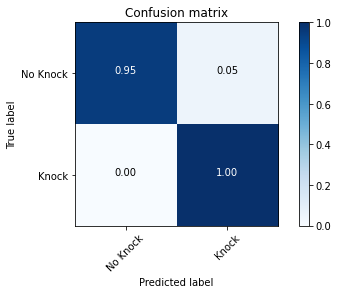

Confusion matrix, without normalization
[[54427  2696]
 [    0 57010]]


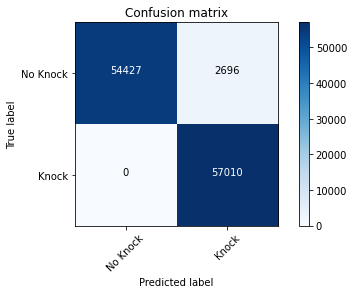

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, train_loader)

#### Validation Set (Balanced)

Accuracy: 94.41
Normalized confusion matrix
[[0.93123233 0.06876767]
 [0.04299584 0.95700416]]


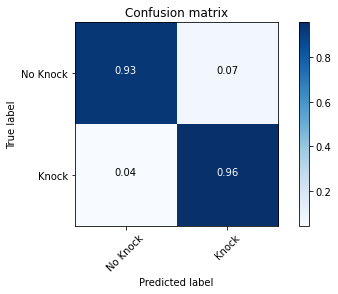

Confusion matrix, without normalization
[[22723  1678]
 [ 1054 23460]]


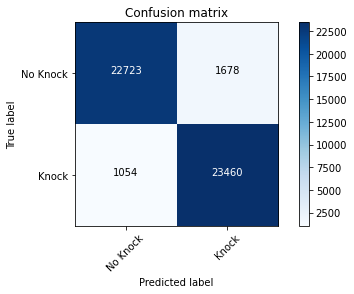

In [ ]:
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, val_loader)

#### Test Set (8k)

Accuracy: 93.67
Normalized confusion matrix
[[0.9327636  0.0672364 ]
 [0.01730312 0.98269688]]


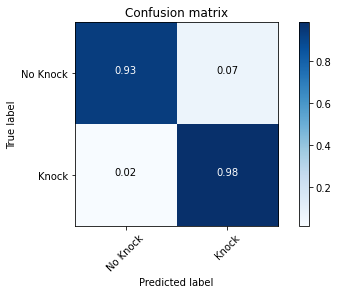

Confusion matrix, without normalization
[[873715  62980]
 [  1406  79851]]


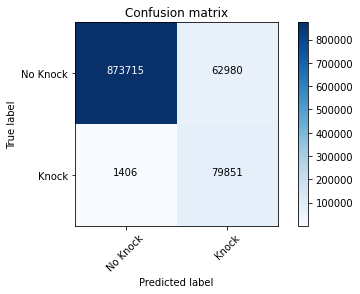

In [ ]:
states = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand8k_test.npy')
labels = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock8k_test.npy')
data_loader = load_data(states, labels)

model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, data_loader)

#### Test Set (2k)

In [ ]:
states_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/curr_hand2k.npy')
label_test = np.load('/content/drive/My Drive/Colab Notebooks/Thesis/data/knock2k.npy')
test_loader = load_data(states_test, label_test)

Accuracy: 95.10
Normalized confusion matrix
[[0.94937621 0.05062379]
 [0.03084631 0.96915369]]


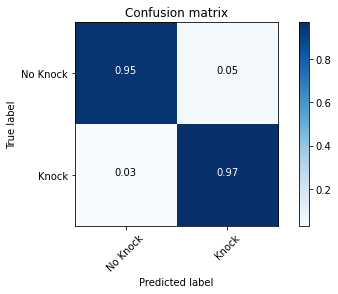

Confusion matrix, without normalization
[[222736  11877]
 [   628  19731]]


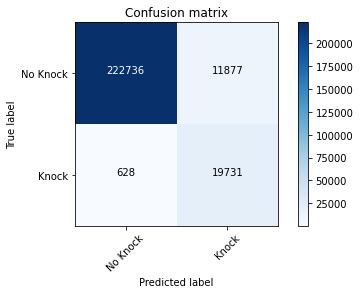

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 94.01
Normalized confusion matrix
[[0.93613312 0.06386688]
 [0.0141952  0.9858048 ]]


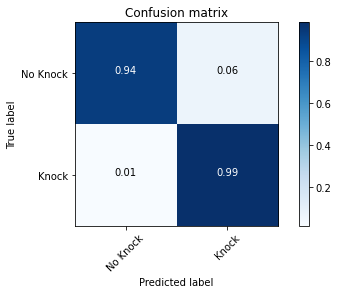

Confusion matrix, without normalization
[[219629  14984]
 [   289  20070]]


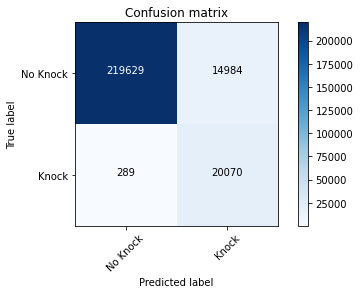

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_acc.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

Accuracy: 93.44
Normalized confusion matrix
[[0.93043864 0.06956136]
 [0.01994204 0.98005796]]


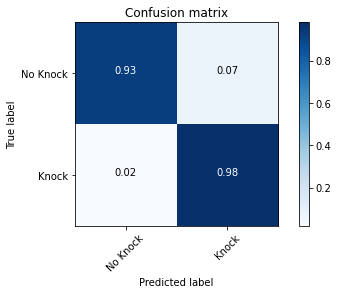

Confusion matrix, without normalization
[[218293  16320]
 [   406  19953]]


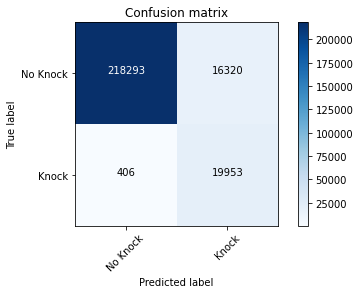

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_loss.pt')
model, loss_fnc, _ = load_model(model=model)
plot_cm(classes, model, test_loader)

## Testing

In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import Card
%cd /content/drive/My Drive/Colab Notebooks/Thesis

def one_hot(cards):
    ret = np.zeros(52)
    for card in cards:
        ret[card.getId()] = 1
    return ret

def un_one_hot(arr):
    rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
    # suitNames = ["C", "H", "S", "D"]
    suitNames = ['S', 'H', 'D', 'C']
    ret = []
    for i in range(len(arr)):
        if arr[i] != 0:
            ret.append(rankNames[i%13] + suitNames[i//13])
    return ret

### Models

#### 104 HU Model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, input_size*2)
        self.l2 = nn.Linear(input_size*2, 1)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        # try:
        #     x = self.l1(features.cuda())
        # except:
        #     x = self.l1(features)
        x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

In [ ]:
# model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/52by5/model.pt')
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model.pt')
# model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/model_loss.pt')

#### 305 HU Model

In [ ]:
class MLP(nn.Module):

    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.l1 = nn.Linear(input_size, 305)
        self.l2 = nn.Linear(305, 1)
        self.sig = nn.Sigmoid()

    def forward(self, features):
        # try:
        #     x = self.l1(features.cuda())
        # except:
        #     x = self.l1(features)
        x = self.l1(features)
        x = self.sig(x)
        x = self.l2(x)
        return self.sig(x)

In [ ]:
model = torch.load('/content/drive/My Drive/Colab Notebooks/Thesis/models/knock_pytorch/305/model.pt')

### Melds

In [ ]:
model

MLP(
  (l1): Linear(in_features=52, out_features=104, bias=True)
  (l2): Linear(in_features=104, out_features=1, bias=True)
  (sig): Sigmoid()
)

#### All Melds

In [ ]:
rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
suitNames = ['S', 'H', 'D', 'C']

melds = []
# Runs
# 3 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 2):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)])
# 4 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 3):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s)])
# 5 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 4):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s)])
# 6 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 5):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s),Card.Card(r+5,s)])
# 7 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 6):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s),Card.Card(r+5,s),Card.Card(r+6,s)])
# 8 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 7):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s),Card.Card(r+5,s),Card.Card(r+6,s)
        ,Card.Card(r+7,s)])
# 9 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 8):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s),Card.Card(r+5,s),Card.Card(r+6,s)
        ,Card.Card(r+7,s),Card.Card(r+8,s)])
# 10 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 9):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
        ,Card.Card(r+3,s),Card.Card(r+4,s),Card.Card(r+5,s),Card.Card(r+6,s)
        ,Card.Card(r+7,s),Card.Card(r+8,s),Card.Card(r+9,s)])
# Sets
# 3 Cards
for r in range(len(rankNames)):
    melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,2)])
    melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,3)])
    melds.append([Card.Card(r,0),Card.Card(r,2),Card.Card(r,3)])
    melds.append([Card.Card(r,1),Card.Card(r,2),Card.Card(r,3)])
# 4 Cards
for r in range(len(rankNames)):
    melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,2),Card.Card(r,3)])
melds = np.array(melds)

melds_oh = []
for i in range(len(melds)):
    melds_oh.append(one_hot(melds[i]))
melds_oh = np.array(melds_oh)

In [ ]:
for i in range(len(model.l1.weight)):
    w = np.array(model.l1.weight[i].tolist())
    res = np.matmul(melds_oh, w)
    ind = (-1*res).argsort()
    print(i, melds[ind][0], res[ind][0], w[np.argwhere(melds_oh[ind][0] == 1)])

5 [7S, 7H, 7D, 7C] 44.91055870056152 [[15.57319832]
 [ 5.94809961]
 [ 2.39208937]
 [20.9971714 ]]
5 [7S, 7H, 7C] 42.51846933364868 [[15.57319832]
 [ 5.94809961]
 [20.9971714 ]]
5 [5S, 6S, 7S, 8S, 9S, TS, JS, QS, KS] 41.95412027835846 [[ 1.00857925]
 [ 2.6007328 ]
 [15.57319832]
 [ 7.31430912]
 [ 9.74324703]
 [ 2.51029038]
 [ 2.06701112]
 [-0.28731692]
 [ 1.42406917]]
5 [3S, 4S, 5S, 6S, 7S, 8S, 9S, TS, JS] 41.26339894533157 [[ 1.22352672]
 [-0.7774958 ]
 [ 1.00857925]
 [ 2.6007328 ]
 [15.57319832]
 [ 7.31430912]
 [ 9.74324703]
 [ 2.51029038]
 [ 2.06701112]]
5 [4S, 5S, 6S, 7S, 8S, 9S, TS, JS, QS, KS] 41.17662447690964 [[-0.7774958 ]
 [ 1.00857925]
 [ 2.6007328 ]
 [15.57319832]
 [ 7.31430912]
 [ 9.74324703]
 [ 2.51029038]
 [ 2.06701112]
 [-0.28731692]
 [ 1.42406917]]
5 [3S, 4S, 5S, 6S, 7S, 8S, 9S, TS, JS, QS] 40.976082026958466 [[ 1.22352672]
 [-0.7774958 ]
 [ 1.00857925]
 [ 2.6007328 ]
 [15.57319832]
 [ 7.31430912]
 [ 9.74324703]
 [ 2.51029038]
 [ 2.06701112]
 [-0.28731692]]
5 [6S, 7S, 8

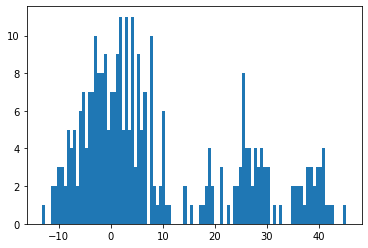

In [ ]:
# i = 0
i=5

w = np.array(model.l1.weight[i].tolist())
res = np.matmul(melds_oh, w)
ind = (-1*res).argsort()
print(i, melds[ind][0], res[ind][0], w[np.argwhere(melds_oh[ind][0] == 1)])
print(i, melds[ind][1], res[ind][1], w[np.argwhere(melds_oh[ind][1] == 1)])
print(i, melds[ind][2], res[ind][2], w[np.argwhere(melds_oh[ind][2] == 1)])
print(i, melds[ind][3], res[ind][3], w[np.argwhere(melds_oh[ind][3] == 1)])
print(i, melds[ind][4], res[ind][4], w[np.argwhere(melds_oh[ind][4] == 1)])
print(i, melds[ind][5], res[ind][5], w[np.argwhere(melds_oh[ind][5] == 1)])
print(i, melds[ind][6], res[ind][6], w[np.argwhere(melds_oh[ind][6] == 1)])
# plt.hist(res,bins=np.arange(res.min(), res.max()+1))
plt.hist(res,bins=np.arange(res.min(), res.max()+1,(res.max()+1 -res.min())/100))
plt.show()

#### 3-4 Card Melds

In [ ]:
rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
suitNames = ['S', 'H', 'D', 'C']

melds = []
# Runs
# 3 Cards
for s in range(len(suitNames)):
    for r in range(len(rankNames) - 2):
        melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)])
# # 4 Cards
# for s in range(len(suitNames)):
#     for r in range(len(rankNames) - 3):
#         melds.append([Card.Card(r,s),Card.Card(r+1,s),Card.Card(r+2,s)
#         ,Card.Card(r+3,s)])

# Sets
# 3 Cards
for r in range(len(rankNames)):
    melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,2)])
    melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,3)])
    melds.append([Card.Card(r,0),Card.Card(r,2),Card.Card(r,3)])
    melds.append([Card.Card(r,1),Card.Card(r,2),Card.Card(r,3)])
# # 4 Cards
# for r in range(len(rankNames)):
#     melds.append([Card.Card(r,0),Card.Card(r,1),Card.Card(r,2),Card.Card(r,3)])

melds = np.array(melds)

melds_oh = []
for i in range(len(melds)):
    melds_oh.append(one_hot(melds[i]))
melds_oh = np.array(melds_oh)

In [ ]:
for i in range(len(model.l1.weight)):
    w = np.array(model.l1.weight[i].tolist())
    res = np.matmul(melds_oh, w)
    ind = (-1*res).argsort()
    print(i, melds[ind][0], res[ind][0], w[np.argwhere(melds_oh[ind][0] == 1)])

5 [7S 7H 7C] 42.51846933364868 [[15.57319832]
 [ 5.94809961]
 [20.9971714 ]]
5 [7S 7D 7C] 38.962459087371826 [[15.57319832]
 [ 2.39208937]
 [20.9971714 ]]
5 [7S 8S 9S] 32.630754470825195 [[15.57319832]
 [ 7.31430912]
 [ 9.74324703]]
5 [6C 7C 8C] 30.52906358242035 [[ 1.70306575]
 [20.9971714 ]
 [ 7.82882643]]
5 [7H 7D 7C] 29.337360382080078 [[ 5.94809961]
 [ 2.39208937]
 [20.9971714 ]]
5 [7C 8C 9C] 27.924299657344818 [[20.9971714 ]
 [ 7.82882643]
 [-0.90169817]]
5 [6S 7S 8S] 25.488240242004395 [[ 2.6007328 ]
 [15.57319832]
 [ 7.31430912]]


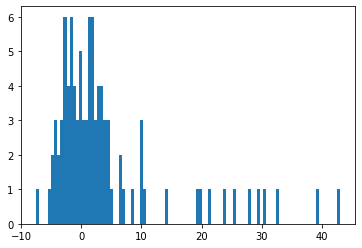

In [ ]:
# i = 0
i=5

w = np.array(model.l1.weight[i].tolist())
res = np.matmul(melds_oh, w)
ind = (-1*res).argsort()
print(i, melds[ind][0], res[ind][0], w[np.argwhere(melds_oh[ind][0] == 1)])
print(i, melds[ind][1], res[ind][1], w[np.argwhere(melds_oh[ind][1] == 1)])
print(i, melds[ind][2], res[ind][2], w[np.argwhere(melds_oh[ind][2] == 1)])
print(i, melds[ind][3], res[ind][3], w[np.argwhere(melds_oh[ind][3] == 1)])
print(i, melds[ind][4], res[ind][4], w[np.argwhere(melds_oh[ind][4] == 1)])
print(i, melds[ind][5], res[ind][5], w[np.argwhere(melds_oh[ind][5] == 1)])
print(i, melds[ind][6], res[ind][6], w[np.argwhere(melds_oh[ind][6] == 1)])
# plt.hist(res,bins=np.arange(res.min(), res.max()+1))
plt.hist(res,bins=np.arange(res.min(), res.max()+1,(res.max()+1 -res.min())/100))
plt.show()

#### Random 3 Card Sets

In [ ]:
import random
rankNames = ["A", "2", "3", "4", "5", "6", "7", "8", "9", "T", "J", "Q", "K"]
suitNames = ['S', 'H', 'D', 'C']

rdm = []
# Random 3 Cards
for i in range(52*51*50):
# for i in range(1000):
    choice = np.arange(0,52,1)
    cards = random.sample(choice.tolist(),  3)
    rdm.append([Card.Card(cards[0]%13,cards[0]//13),Card.Card(cards[1]%13,cards[1]//13),Card.Card(cards[2]%13,cards[2]//13)])

rdm = np.array(rdm)

rdm_oh = []
for i in range(len(rdm)):
    rdm_oh.append(one_hot(rdm[i]))
rdm_oh = np.array(rdm_oh)

rdm=np.concatenate((rdm,melds))
rdm_oh=np.concatenate((rdm_oh,melds_oh))

In [ ]:
for i in range(len(model.l1.weight)):
    w = np.array(model.l1.weight[i].tolist())
    res = np.matmul(rdm_oh, w)
    ind = (-1*res).argsort()
    print(i, rdm[ind][0], res[ind][0], w[np.argwhere(rdm_oh[ind][0] == 1)])

5 [7C 7S 9S] 46.31361675262451 [[15.57319832]
 [ 9.74324703]
 [20.9971714 ]]
5 [8C 7C 7S] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]
5 [7S 7C 8C] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]
5 [7C 8C 7S] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]
5 [8C 7C 7S] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]
5 [7S 8C 7C] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]
5 [7C 8C 7S] 44.3991961479187 [[15.57319832]
 [20.9971714 ]
 [ 7.82882643]]


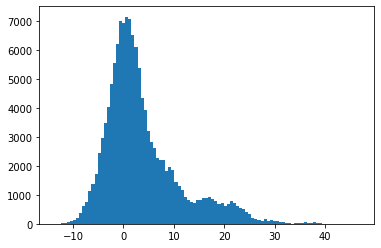

In [ ]:
# i = 10
i = 5

w = np.array(model.l1.weight[i].tolist())
res = np.matmul(rdm_oh, w)
ind = (-1*res).argsort()
print(i, rdm[ind][0], res[ind][0], w[np.argwhere(rdm_oh[ind][0] == 1)])
print(i, rdm[ind][1], res[ind][1], w[np.argwhere(rdm_oh[ind][1] == 1)])
print(i, rdm[ind][2], res[ind][2], w[np.argwhere(rdm_oh[ind][2] == 1)])
print(i, rdm[ind][3], res[ind][3], w[np.argwhere(rdm_oh[ind][3] == 1)])
print(i, rdm[ind][4], res[ind][4], w[np.argwhere(rdm_oh[ind][4] == 1)])
print(i, rdm[ind][5], res[ind][5], w[np.argwhere(rdm_oh[ind][5] == 1)])
print(i, rdm[ind][6], res[ind][6], w[np.argwhere(rdm_oh[ind][6] == 1)])
# plt.hist(res,bins=np.arange(res.min(), res.max()+1))
plt.hist(res,bins=np.arange(res.min(), res.max()+1,(res.max()+1 -res.min())/100))
plt.show()

In [ ]:
w = model.l1.weight[i]
ind = w.argsort(descending=True)
for c in ind:#(len(model.l1.weight[0])):
    print(Card.Card(c%13,c//13), np.around(w[c].item(),4))

7C 20.9972
7S 15.5732
9S 9.7432
8C 7.8288
8S 7.3143
7H 5.9481
TH 3.3356
6S 2.6007
TS 2.5103
6H 2.4866
7D 2.3921
JS 2.067
5H 2.0164
KH 1.7766
6C 1.7031
JH 1.5014
KS 1.4241
9D 1.2721
3S 1.2235
2H 1.1558
KD 1.0599
5S 1.0086
QC 0.9393
QD 0.9279
KC 0.7533
2C 0.6989
JC 0.5223
4D 0.4669
3H 0.1435
QH -0.19
QS -0.2873
4H -0.3541
JD -0.4433
AS -0.545
2D -0.6335
TC -0.6955
4S -0.7775
2S -0.7984
9C -0.9017
5C -1.1876
3C -1.2549
AH -1.2828
AC -1.2868
3D -1.4574
5D -1.6777
4C -2.2342
AD -2.3306
9H -2.3915
6D -2.3982
TD -3.781
8H -4.8281
8D -5.0525


(array([2., 0., 1., 0., 2., 2., 4., 5., 7., 1., 4., 8., 3., 5., 1., 1., 0.,
        0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.]),
 array([-5.05252123, -4.51152738, -3.97053352, -3.42953967, -2.88854582,
        -2.34755197, -1.80655811, -1.26556426, -0.72457041, -0.18357656,
         0.3574173 ,  0.89841115,  1.439405  ,  1.98039886,  2.52139271,
         3.06238656,  3.60338041,  4.14437427,  4.68536812,  5.22636197,
         5.76735582,  6.30834968,  6.84934353,  7.39033738,  7.93133123,
         8.47232509,  9.01331894,  9.55431279, 10.09530664, 10.6363005 ,
        11.17729435, 11.7182882 , 12.25928205, 12.80027591, 13.34126976,
        13.88226361, 14.42325747, 14.96425132, 15.50524517, 16.04623902,
        16.58723288, 17.12822673, 17.66922058, 18.21021443, 18.75120829,
        19.29220214, 19.83319599, 20.37418984, 20.9151837 , 21.45617755]),
 <a list of 49 Patch objects>)

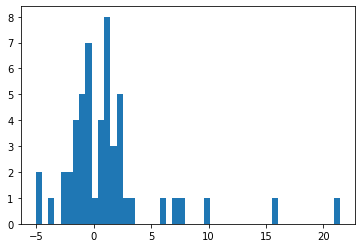

In [ ]:
# weight distribution
res = np.array(model.l1.weight[i].tolist())
plt.hist(res,bins=np.arange(res.min(), res.max()+1,(res.max()+1 -res.min())/50))

(array([ 1.,  2.,  4.,  0.,  0.,  0.,  0.,  1.,  2.,  0.,  0.,  0.,  1.,
         2.,  0.,  4., 10.,  3.,  5.,  2.,  0.,  5.,  6.,  2.,  3.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  8.,
         8.,  8.,  6.,  4.,  5.,  2.,  3.,  0.,  1.,  0.]),
 array([-10.51631069, -10.16413974,  -9.81196878,  -9.45979783,
         -9.10762688,  -8.75545592,  -8.40328497,  -8.05111402,
         -7.69894306,  -7.34677211,  -6.99460115,  -6.6424302 ,
         -6.29025925,  -5.93808829,  -5.58591734,  -5.23374639,
         -4.88157543,  -4.52940448,  -4.17723352,  -3.82506257,
         -3.47289162,  -3.12072066,  -2.76854971,  -2.41637876,
         -2.0642078 ,  -1.71203685,  -1.35986589,  -1.00769494,
         -0.65552399,  -0.30335303,   0.04881792,   0.40098887,
          0.75315983,   1.10533078,   1.45750174,   1.80967269,
          2.16184364,   2.5140146 ,   2.86618555,   3.2183565 ,
          3.57052746,   3.92269841,   4.27486937,   4.62704032,
          4.97921

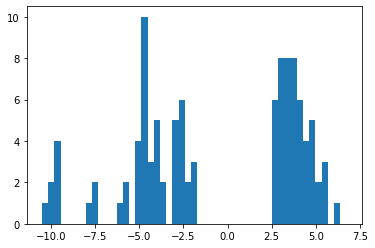

In [ ]:
# weight distribution for layer 2
res = np.array(model.l2.weight[0].tolist())
plt.hist(res,bins=np.arange(res.min(), res.max()+1,(res.max()+1 -res.min())/50))

In [ ]:
w = model.l1.weight[0]
ind = w.argsort(descending=True)
for i in ind:#(len(model.l1.weight[0])):
    print(Card.Card(i%13,i//13), np.around(w[i].item(),4))

6H 2.903
4H 2.3884
JH 1.715
QH 1.4192
7C 1.393
TH 1.0542
8H 1.0463
9S 1.0435
AH 0.993
9D 0.9319
3S 0.8829
2H 0.8292
8S 0.7676
2D 0.6772
TD 0.6615
AD 0.4873
2S 0.4704
JS 0.4006
8C 0.3121
JD 0.2852
AS 0.2493
QS 0.2484
2C 0.1981
7H 0.1917
9C 0.1443
AC 0.1418
TC 0.1068
7D 0.071
3C 0.055
3D 0.0518
QC -0.0224
8D -0.0382
3H -0.0869
QD -0.439
JC -0.5071
7S -0.5363
TS -0.6025
9H -0.607
4D -0.9269
4S -0.935
6S -1.1609
6D -1.568
6C -1.8265
5H -1.8787
4C -2.2463
KH -2.7088
5D -2.8574
5C -3.3168
5S -3.8934
KS -5.4711
KD -6.2767
KC -9.6759


In [ ]:
%cd /content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
import Card
%cd /content/drive/My Drive/Colab Notebooks/Thesis
# suit_list = ['S', 'H', 'D', 'C']
# rank_list = ['A', '2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K']
# C -> H -> S -> D
# 0 -> 1 -> 2 -> 3

# A -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> J -> Q -> K
# 0 -> 1 -> 2 -> 3 -> 4 -> 5 -> 6 -> 7 -> 8 -> 9 -> 10 -> 11 -> 12
# Card.Card(6, 0)

allCards = []
suit = 0
rank = 0
for s in range(Card.Card.NUM_SUITS):
    for r in range(Card.Card.NUM_RANKS):
        c = Card.Card(r, s)
        print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else " "), end="")
        # print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        # print(str(c) + ("\n" if r == Card.Card.NUM_RANKS - 1 else "\t\t"), end="")
        allCards += [c]
    rank = 1
    for r in range(Card.Card.NUM_RANKS):
        print(str(suit*13 + rank) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else " "), end="")
        # print(str(suit*13 + rank) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        # print(str(r)+ ', ' + str(s) + ("\n\n" if r == Card.Card.NUM_RANKS - 1 else "\t"), end="")
        rank += 1
    suit += 1

/content/drive/My Drive/Colab Notebooks/Thesis/GinRummy
/content/drive/My Drive/Colab Notebooks/Thesis
AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS
1 2 3 4 5 6 7 8 9 10 11 12 13

AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH
14 15 16 17 18 19 20 21 22 23 24 25 26

AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD
27 28 29 30 31 32 33 34 35 36 37 38 39

AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC
40 41 42 43 44 45 46 47 48 49 50 51 52



In [ ]:
'''
AS	2S	3S	4S	5S	6S	7S	8S	9S	TS	JS	QS	KS
1	2	3	4	5	6	7	8	9	10	11	12	13

AH	2H	3H	4H	5H	6H	7H	8H	9H	TH	JH	QH	KH
14	15	16	17	18	19	20	21	22	23	24	25	26

AD	2D	3D	4D	5D	6D	7D	8D	9D	TD	JD	QD	KD
27	28	29	30	31	32	33	34	35	36	37	38	39

AC	2C	3C	4C	5C	6C	7C	8C	9C	TC	JC	QC	KC
40	41	42	43	44	45	46	47	48	49	50	51	52


        --------------------------------------        Number          ---------------------------------------
        A       2       3       4       5       6       7       8       9       T      J       Q       K

S       AS		2S		3S		4S		5S		6S		7S		8S		9S		TS		JS		QS		KS
        0, 0	1, 0	2, 0	3, 0	4, 0	5, 0	6, 0	7, 0	8, 0	9, 0	10, 0	11, 0	12, 0

H       AH		2H		3H		4H		5H		6H		7H		8H		9H		TH		JH		QH		KH
        0, 1	1, 1	2, 1	3, 1	4, 1	5, 1	6, 1	7, 1	8, 1	9, 1	10, 1	11, 1	12, 1

D       AD		2D		3D		4D		5D		6D		7D		8D		9D		TD		JD		QD		KD
        0, 2	1, 2	2, 2	3, 2	4, 2	5, 2	6, 2	7, 2	8, 2	9, 2	10, 2	11, 2	12, 2

C       AC		2C		3C		4C		5C		6C		7C		8C		9C		TC		JC		QC		KC
        0, 3	1, 3	2, 3	3, 3	4, 3	5, 3	6, 3	7, 3	8, 3	9, 3	10, 3	11, 3	12, 3

'''


# KS -9.9002
# KD -10.3559
# KC -19.302

hand = [Card.Card(12, 0),
        Card.Card(12, 2),
        Card.Card(12, 3)]


# (r, s)
# 
# [[6S, 7S, 8S, 9S], [3C, 3H, 3D], 4C, AH, AC]
# hand = [Card.Card(5, 2),
#         Card.Card(6, 2),
#         Card.Card(7, 2),
#         Card.Card(8, 2),

#         Card.Card(2, 0),
#         Card.Card(2, 0),
#         Card.Card(2, 0),

#         Card.Card(3, 0),
#         Card.Card(0, 0),
#         Card.Card(0, 1)]

input = one_hot(hand)
input = np.expand_dims(input,axis=0)
# GinRummyUtil.getDeadwoodPoints3(input)
model(torch.from_numpy(input).type(torch.FloatTensor))

tensor([[1.]], grad_fn=<SigmoidBackward>)

### Function Definition

In [ ]:
allCardsNames = 'AC 2C 3C 4C 5C 6C 7C 8C 9C TC JC QC KC AH 2H 3H 4H 5H 6H 7H 8H 9H TH JH QH KH AS 2S 3S 4S 5S 6S 7S 8S 9S TS JS QS KS AD 2D 3D 4D 5D 6D 7D 8D 9D TD JD QD KD'
allCardsNamesArr = allCardsNames.split(' ')
allCards = []
for cardName in allCardsNamesArr:
    allCards.append(Deck.strCardMap[cardName])

def meldedHand(cards):
    unmeldedCards = cards.copy()
    bestMelds = GinRummyUtil.cardsToBestMeldSets(unmeldedCards)
    if len(bestMelds) == 0:
        melds = unmeldedCards
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    else:
        melds = bestMelds[0]
        for meld in melds:
            # print(meld)
            for card in meld:
                # print(card)
                # print(unmeldedCards)
                unmeldedCards.remove(card)
        melds.extend(unmeldedCards)
        deadwood = GinRummyUtil.getDeadwoodPoints3(unmeldedCards)
    return melds, deadwood

def testHand(cards):
    meldSet, deadwood = meldedHand(cards)
    print("%s with %d deadwood." % (meldSet, deadwood))
    label = deadwood <= 10
    input = one_hot(cards)
    input = np.expand_dims(input,axis=0)
    prob = float(model(torch.from_numpy(input).type(torch.FloatTensor)))
    print('Predicted Output:', prob)
    guess = prob > 0.5
    if guess and label: # TN
        print('Correct! Model guessed knocked')
        return 'TN'
        # pass
    elif not guess and not label: # TP
        print('Correct! Model guessed NOT knocked')
        return 'TP'
        # pass
    elif guess and not label:   #FP
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed knocked')
        print('\n\n')
        return 'FP'
    elif not guess and label: # FN
        # print("%s with %d deadwood." % (meldSet, deadwood))
        # print('Predicted Output:', prob)
        print('Incorrect! Model guessed NOT knocked')
        print('\n\n')
        return 'FN'

In [ ]:
cardNames = '[AS, AH, AC, 2C, 3C, 4C, 4H, 4D, 4S, 5C]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
testHand(hand)


### Random Hand (Not Knocked)

In [ ]:
cardNames = '[KC, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[AC, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 62 deadwood.
Predicted Output: 1.0098742182123102e-13
Correct! Model guessed NOT knocked
[2C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 63 deadwood.
Predicted Output: 8.054092061251378e-14
Correct! Model guessed NOT knocked
[3C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 64 deadwood.
Predicted Output: 3.161378157361469e-16
Correct! Model guessed NOT knocked
[[4C, 4H, 4S], 7D, 2D, 9D, 7H, KH, TH, 8S] with 53 deadwood.
Predicted Output: 2.3903401908656127e-14
Correct! Model guessed NOT knocked
[5C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 66 deadwood.
Predicted Output: 5.931410046553388e-15
Correct! Model guessed NOT knocked
[6C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 67 deadwood.
Predicted Output: 1.1841192800864531e-14
Correct! Model guessed NOT knocked
[[7C, 7H, 7D], 2D, 9D, 4H, KH, TH, 8S, 4S] with 47 deadwood.
Predicted Output: 8.848191512811354e-09
Correct! Model guessed NOT knocked
[8C, 7D, 2D, 9D, 7H, 4H, KH, TH, 8S, 4S] with 69 deadwo

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:53: RuntimeWarning: invalid value encountered in true_divide


Normalized confusion matrix
[[ 1.  0.]
 [nan nan]]


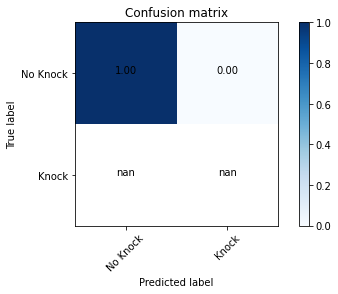

Confusion matrix, without normalization
[[430   0]
 [  0   0]]


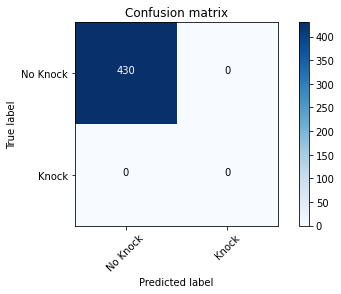

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (GIN)

In [ ]:
cardNames = '[[2C, 3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D]]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[2C, 3C, 4C, 5C], [AC, AH, AS], [4H, 4S, 4D]] with 0 deadwood.
Predicted Output: 0.9999998807907104
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], 6C] with 6 deadwood.
Predicted Output: 0.9998270869255066
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], 7C] with 7 deadwood.
Predicted Output: 0.9801596403121948
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], 8C] with 8 deadwood.
Predicted Output: 0.9674043655395508
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], 9C] with 9 deadwood.
Predicted Output: 0.9999996423721313
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], TC] with 10 deadwood.
Predicted Output: 1.0
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], JC] with 10 deadwood.
Predicted Output: 1.0
Correct! Model guessed knocked
[[2C, 3C, 4C], [AC, AH, AS], [4H, 4S, 4D], QC] with 10 deadwood.
Predicted Output: 0.9999996423721313
Co

Normalized confusion matrix
[[0.02272727 0.97727273]
 [0.07591623 0.92408377]]


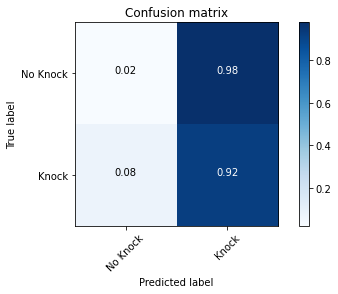

Confusion matrix, without normalization
[[  1  43]
 [ 29 353]]


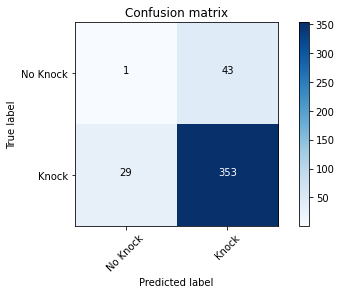

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 4 Deadwood (1 card))

In [ ]:
cardNames = '[[2C, 2H, 2D], [6C, 6H, 6D], [7H, 7S, 7D], 4D]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[6C, 6H, 6D], [7H, 7S, 7D], AC, 2H, 2D, 4D] with 9 deadwood.
Predicted Output: 0.997921884059906
Correct! Model guessed knocked
[[2C, 2H, 2D], [6C, 6H, 6D], [7H, 7S, 7D], 4D] with 4 deadwood.
Predicted Output: 0.99928879737854
Correct! Model guessed knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 3C, 2H, 2D, 4D] with 11 deadwood.
Predicted Output: 0.001584522076882422
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 4C, 2H, 2D, 4D] with 12 deadwood.
Predicted Output: 0.2507537007331848
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 5C, 2H, 2D, 4D] with 13 deadwood.
Predicted Output: 0.016100222244858742
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7C, 7H, 7S, 7D], 2H, 2D, 4D] with 8 deadwood.
Predicted Output: 0.9994474053382874
Correct! Model guessed knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 8C, 2H, 2D, 4D] with 16 deadwood.
Predicted Output: 0.0005819512880407274
Correct! Model guessed NOT knocked
[[6C, 6H, 6D], [7H, 7S, 7D], 9C, 2H, 2D, 4D] with 17 deadwood.
P

Normalized confusion matrix
[[0.89913545 0.10086455]
 [0.18072289 0.81927711]]


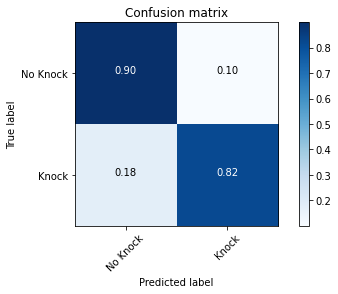

Confusion matrix, without normalization
[[312  35]
 [ 15  68]]


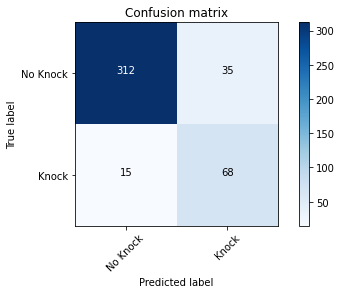

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 7 Deadwood (2 cards))

In [ ]:
cardNames = '[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[4D, 5D, 6D, 7D, 8D], 2C, 4S, 5S, 6H, AC] with 18 deadwood.
Predicted Output: 0.0029929925221949816
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 3C, 4S, 5S, 6H, AC] with 19 deadwood.
Predicted Output: 0.0038953260518610477
Correct! Model guessed NOT knocked
[[5D, 6D, 7D, 8D], [4C, 4S, 4D], 5S, 6H, AC] with 12 deadwood.
Predicted Output: 0.0037637329660356045
Correct! Model guessed NOT knocked
[[6D, 7D, 8D], [5C, 5S, 5D], 4S, 4D, 6H, AC] with 15 deadwood.
Predicted Output: 0.022379109635949135
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 6C, 4S, 5S, 6H, AC] with 22 deadwood.
Predicted Output: 0.0011085051810368896
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 7C, 4S, 5S, 6H, AC] with 23 deadwood.
Predicted Output: 0.03890501707792282
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 8C, 4S, 5S, 6H, AC] with 24 deadwood.
Predicted Output: 3.60256562998984e-05
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 9C, 4S, 5S, 6H, AC] with 

Normalized confusion matrix
[[0.81303116 0.18696884]
 [0.18421053 0.81578947]]


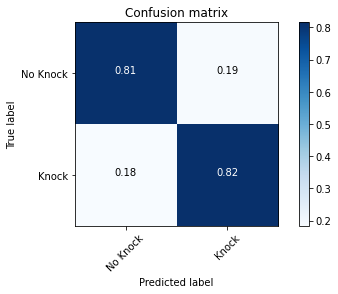

Confusion matrix, without normalization
[[287  66]
 [ 14  62]]


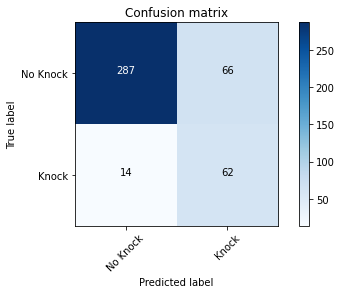

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 16 Deadwood (2 cards))

In [ ]:
cardNames = '[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, TC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
testHand(hand)
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[3S, 4S, 5S], [4D, 5D, 6D, 7D, 8D], 6H, TC] with 16 deadwood.
Predicted Output: 0.08454505354166031
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], AC, 4S, 5S, 6H, TC] with 26 deadwood.
Predicted Output: 0.2570951581001282
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 2C, 4S, 5S, 6H, TC] with 27 deadwood.
Predicted Output: 0.0023202819284051657
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 3C, 4S, 5S, 6H, TC] with 28 deadwood.
Predicted Output: 0.004671168979257345
Correct! Model guessed NOT knocked
[[5D, 6D, 7D, 8D], [4C, 4S, 4D], 5S, 6H, TC] with 21 deadwood.
Predicted Output: 0.00018194402218796313
Correct! Model guessed NOT knocked
[[6D, 7D, 8D], [5C, 5S, 5D], 4S, 4D, 6H, TC] with 24 deadwood.
Predicted Output: 6.281433888943866e-05
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 6C, 4S, 5S, 6H, TC] with 31 deadwood.
Predicted Output: 0.0006640617502853274
Correct! Model guessed NOT knocked
[[4D, 5D, 6D, 7D, 8D], 7C, 4S, 5S, 6H, TC] with

Normalized confusion matrix
[[0.88321168 0.11678832]
 [0.31578947 0.68421053]]


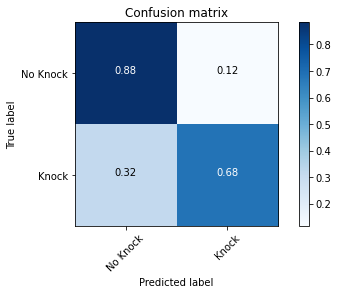

Confusion matrix, without normalization
[[363  48]
 [  6  13]]


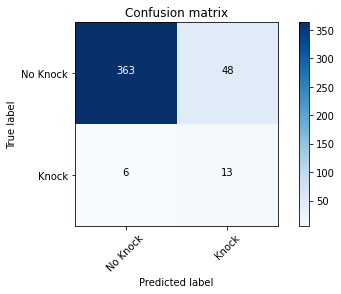

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 6 Deadwood (3 cards))

In [ ]:
cardNames = '[[6S, 7S, 8S, 9S], [3C, 3H, 3D], 4C, AH, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[AC, 2C, 3C, 4C], [7S, 8S, 9S], 3H, 3D, AH] with 7 deadwood.
Predicted Output: 0.999775230884552
Correct! Model guessed knocked
[[3C, 4C, 5C], [7S, 8S, 9S], 3H, 3D, AH, AC] with 8 deadwood.
Predicted Output: 0.999365508556366
Correct! Model guessed knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 6C, 4C, AH, AC] with 12 deadwood.
Predicted Output: 3.565087536117062e-05
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 7C, 4C, AH, AC] with 13 deadwood.
Predicted Output: 5.165955371921882e-05
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 8C, 4C, AH, AC] with 14 deadwood.
Predicted Output: 0.0005967427277937531
Correct! Model guessed NOT knocked
[[7S, 8S, 9S], [3C, 3H, 3D], 9C, 4C, AH, AC] with 15 deadwood.
Predicted Output: 0.7847893834114075
Incorrect! Model guessed knocked



[[7S, 8S, 9S], [3C, 3H, 3D], TC, 4C, AH, AC] with 16 deadwood.
Predicted Output: 0.8659716248512268
Incorrect! Model guessed knocked



[[7S, 8S, 9S], [3C, 3H, 3D], JC, 4C, AH, AC] with 16 dea

Normalized confusion matrix
[[0.82568807 0.17431193]
 [0.11764706 0.88235294]]


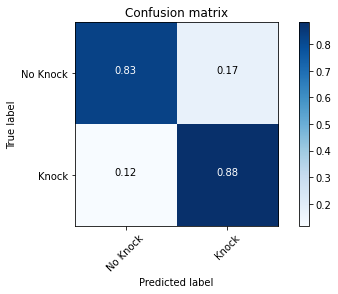

Confusion matrix, without normalization
[[270  57]
 [ 12  90]]


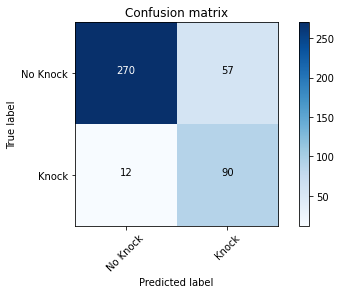

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

### Variations of Knocked Hand (initial 11 Deadwood (4 cards))


In [ ]:
cardNames = '[[8C, 8H, 8D], [JC, JH, JS], 5S, 4H, AD, AC]'
cardNameArr = cardNames.replace('[', '').replace(']', '').replace('  ', ' ').split(', ')
hand = []
for cardName in cardNameArr:
    hand.append(Deck.strCardMap[cardName])
# testHand(hand)
tn = 0
tp = 0
fp = 0
fn = 0
for c in range(10):
    hand2 = hand.copy()
    for newcard in allCards:
        if (one_hot([newcard]) == one_hot(hand2[:])).sum() == 41:
            hand2[c] = newcard
            ret = testHand(hand2)
            if ret == 'TN':
                tn += 1
            elif ret == 'TP':
                tp += 1
            elif ret == 'FP':
                fp += 1
            elif ret == 'FN':
                fn += 1

[[JC, JH, JS], 2C, 8H, 8D, 5S, 4H, AD, AC] with 29 deadwood.
Predicted Output: 2.7548443881642015e-07
Correct! Model guessed NOT knocked
[[JC, JH, JS], 3C, 8H, 8D, 5S, 4H, AD, AC] with 30 deadwood.
Predicted Output: 7.218058373226199e-10
Correct! Model guessed NOT knocked
[[JC, JH, JS], 4C, 8H, 8D, 5S, 4H, AD, AC] with 31 deadwood.
Predicted Output: 2.4564708382968092e-06
Correct! Model guessed NOT knocked
[[JC, JH, JS], 5C, 8H, 8D, 5S, 4H, AD, AC] with 32 deadwood.
Predicted Output: 1.7969317411825614e-07
Correct! Model guessed NOT knocked
[[JC, JH, JS], 6C, 8H, 8D, 5S, 4H, AD, AC] with 33 deadwood.
Predicted Output: 2.6513027329144734e-09
Correct! Model guessed NOT knocked
[[JC, JH, JS], 7C, 8H, 8D, 5S, 4H, AD, AC] with 34 deadwood.
Predicted Output: 1.3385347246829687e-13
Correct! Model guessed NOT knocked
[[8C, 8H, 8D], [JC, JH, JS], 5S, 4H, AD, AC] with 11 deadwood.
Predicted Output: 0.2162780910730362
Correct! Model guessed NOT knocked
[[JC, JH, JS], 9C, 8H, 8D, 5S, 4H, AD, AC] w

Normalized confusion matrix
[[0.82568807 0.17431193]
 [0.11764706 0.88235294]]


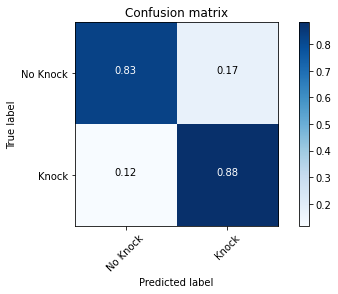

Confusion matrix, without normalization
[[270  57]
 [ 12  90]]


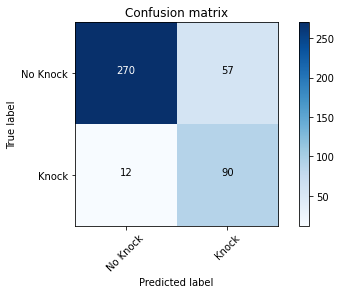

In [ ]:
cm = np.array([[tp,fp],[fn,tn]])
classes = ["No Knock", "Knock"]
plot_confusion_matrix('', cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)
plot_confusion_matrix('', cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)